##### Copyright 2021 The TensorFlow Authors.

# Setup

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1mgSzRqhA_ip0__4RXeOu0JCoTp-yzINC

In [ ]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
spec = model_spec.get('efficientdet_lite0')

In [ ]:
!unzip dataset.zip

In [ ]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('speedbumps.csv')

In [ ]:
#3h42min de treino - cronometrar para retirar model

model = object_detector.create(train_data, model_spec=spec, batch_size=32, train_whole_model=True, validation_data=validation_data)

In [ ]:
model.evaluate(test_data)

In [ ]:
model.export(export_dir='.')

# Object Detection with TensorFlow Lite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/models/modify/model_maker/object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/models/modify/model_maker/object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker) library to train a custom object detection model capable of detecting salads within images on a mobile device.

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.

You'll use the publicly available *Salads* dataset, which was created from the [Open Images Dataset V4](https://storage.googleapis.com/openimages/web/index.html).

Each image in the dataset contains objects labeled as one of the following classes:
* Baked Good
* Cheese
* Salad
* Seafood
* Tomato

The dataset contains the bounding-boxes specifying where each object locates, together with the object's label.

Here is an example image from the dataset:

<br/>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="0">




## Prerequisites


### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [ ]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 22 not upgraded.
Need to get 65.4 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libportaudio2 amd64 19.6.0-1build1 [65.4 kB]
Fetched 65.4 kB in 1s (68.0 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 128275

Import the required packages.

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


### Prepare the dataset

Here you'll use the same dataset as the AutoML [quickstart](https://cloud.google.com/vision/automl/object-detection/docs/edge-quickstart#preparing_a_dataset).

The *Salads* dataset is available at:
 `gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv`.

It contains 175 images for training, 25 images for validation, and 25 images for testing. The dataset has five classes: `Salad`, `Seafood`, `Tomato`, `Baked goods`, `Cheese`.

<br/>

The dataset is provided in CSV format:
```
TRAINING,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Salad,0.0,0.0954,,,0.977,0.957,,
VALIDATION,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Seafood,0.0154,0.1538,,,1.0,0.802,,
TEST,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Tomato,0.0,0.655,,,0.231,0.839,,
```

* Each row corresponds to an object localized inside a larger image, with each object specifically designated as test, train, or validation data. You'll learn more about what that means in a later stage in this notebook.
* The three lines included here indicate **three distinct objects located inside the same image** available at `gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg`.
* Each row has a different label: `Salad`, `Seafood`, `Tomato`, etc.
* Bounding boxes are specified for each image using the top left and bottom right vertices.

Here is a visualzation of these three lines:

<br>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="100">

If you want to know more about how to prepare your own CSV file and the minimum requirements for creating a valid dataset, see the [Preparing your training data](https://cloud.google.com/vision/automl/object-detection/docs/prepare) guide for more details.

If you are new to Google Cloud, you may wonder what the `gs://` URL means. They are URLs of files stored on [Google Cloud Storage](https://cloud.google.com/storage) (GCS). If you make your files on GCS public or [authenticate your client](https://cloud.google.com/storage/docs/authentication#libauth), Model Maker can read those files similarly to your local files.

However, you don't need to keep your images on Google Cloud to use Model Maker. You can use a local path in your CSV file and Model Maker will just work.

## Quickstart

There are six steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite0 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [ ]:
spec = model_spec.get('efficientdet_lite0')

**Step 2. Load the dataset.**

Model Maker will take input data in the CSV format. Use the `object_detector.DataLoader.from_csv` method to load the dataset and split them into the training, validation and test images.

* Training images: These images are used to train the object detection model to recognize salad ingredients.
* Validation images: These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).
* Test images: These images are used to evaluate the final model performance.

You can load the CSV file directly from Google Cloud Storage, but you don't need to keep your images on Google Cloud to use Model Maker. You can specify a local CSV file on your computer, and Model Maker will work just fine.

In [ ]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv')

**Step 3. Train the TensorFlow model with the training data.**

* The EfficientDet-Lite0 model uses `epochs = 50` by default, which means it will go through the training dataset 50 times. You can look at the validation accuracy during training and stop early to avoid overfitting.
* Set `batch_size = 8` here so you will see that it takes 21 steps to go through the 175 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [ ]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, train_whole_model=True, validation_data=validation_data)

Epoch 1/50
4/4 [==============================] - 48s 2s/step - det_loss: 2.0653 - cls_loss: 1.1748 - box_loss: 0.0178 - reg_l2_loss: 0.0630 - loss: 2.1283 - learning_rate: 0.0089 - gradient_norm: 1.7969 - val_det_loss: 2.2015 - val_cls_loss: 1.1647 - val_box_loss: 0.0207 - val_reg_l2_loss: 0.0630 - val_loss: 2.2645
Epoch 2/50
4/4 [==============================] - 5s 2s/step - det_loss: 1.9964 - cls_loss: 1.1411 - box_loss: 0.0171 - reg_l2_loss: 0.0630 - loss: 2.0594 - learning_rate: 0.0100 - gradient_norm: 1.4726 - val_det_loss: 2.1219 - val_cls_loss: 1.1340 - val_box_loss: 0.0198 - val_reg_l2_loss: 0.0630 - val_loss: 2.1849
Epoch 3/50
4/4 [==============================] - 4s 1s/step - det_loss: 2.0523 - cls_loss: 1.1352 - box_loss: 0.0183 - reg_l2_loss: 0.0630 - loss: 2.1153 - learning_rate: 0.0099 - gradient_norm: 1.8570 - val_det_loss: 2.0208 - val_cls_loss: 1.0958 - val_box_loss: 0.0185 - val_reg_l2_loss: 0.0630 - val_loss: 2.0838
Epoch 4/50
4/4 [==============================] 

**Step 4. Evaluate the model with the test data.**

After training the object detection model using the images in the training dataset, use the remaining 25 images in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 25 images in the test dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [ ]:
model.evaluate(test_data)

1/1 [==============================] - 4s 4s/step



{'AP': 0.7117639,
 'AP50': 1.0,
 'AP75': 1.0,
 'APs': -1.0,
 'APm': 0.71341264,
 'APl': -1.0,
 'ARmax1': 0.51428574,
 'ARmax10': 0.75714284,
 'ARmax100': 0.75714284,
 'ARs': -1.0,
 'ARm': 0.75714284,
 'ARl': -1.0,
 'AP_/SpeedBumpSign': 0.7117639}

**Step 5.  Export as a TensorFlow Lite model.**

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is full integer quantization.

In [ ]:
model.export(export_dir='.')

**Step 6.  Evaluate the TensorFlow Lite model.**

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [ ]:
model.evaluate_tflite('model.tflite', test_data)

5/5 [==============================] - 15s 3s/step



{'AP': 0.71609616,
 'AP50': 1.0,
 'AP75': 1.0,
 'APs': -1.0,
 'APm': 0.71609616,
 'APl': -1.0,
 'ARmax1': 0.51428574,
 'ARmax10': 0.7285714,
 'ARmax100': 0.7285714,
 'ARs': -1.0,
 'ARm': 0.7285714,
 'ARl': -1.0,
 'AP_/SpeedBumpSign': 0.71609616}

You can download the TensorFlow Lite model file using the left sidebar of Colab. Right-click on the `model.tflite` file and choose `Download` to download it to your local computer.

This model can be integrated into an Android or an iOS app using the [ObjectDetector API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

See the [TFLite Object Detection sample app](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android) for more details on how the model is used in an working app.

*Note: Android Studio Model Binding does not support object detection yet so please use the TensorFlow Lite Task Library.*

## (Optional) Test the TFLite model on your image

You can test the trained TFLite model using images from the internet.
* Replace the `INPUT_IMAGE_URL` below with your desired input image.
* Adjust the `DETECTION_THRESHOLD` to change the sensitivity of the model. A lower threshold means the model will pickup more objects but there will also be more false detection. Meanwhile, a higher threshold means the model will only pickup objects that it has confidently detected.

Although it requires some of boilerplate code to run the model in Python at this moment, integrating the model into a mobile app only requires a few lines of code.

In [ ]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# classes = ['SpeedBumpSign']

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])
    
    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

  #https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg
  #https://www.portaldotransito.com.br/wp-content/uploads/2022/11/lombada-original.jpg

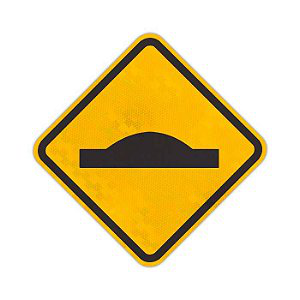

In [ ]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "https://cdn.awsli.com.br/300x300/1012/1012749/produto/37704877/b052fc6bc7.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

## (Optional) Compile For the Edge TPU

Now that you have a quantized EfficientDet Lite model, it is possible to compile and deploy to a [Coral EdgeTPU](https://coral.ai/).

**Step 1. Install the EdgeTPU Compiler**

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

**Step 2. Select number of Edge TPUs, Compile**

The EdgeTPU has 8MB of SRAM for caching model paramaters ([more info](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching)). This means that for models that are larger than 8MB, inference time will be increased in order to transfer over model paramaters. One way to avoid this is [Model Pipelining](https://coral.ai/docs/edgetpu/pipeline/) - splitting the model into segments that can have a dedicated EdgeTPU. This can significantly improve latency.

The below table can be used as a reference for the number of Edge TPUs to use - the larger models will not compile for a single TPU as the intermediate tensors can't fit in on-chip memory.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

In [ ]:
NUMBER_OF_TPUS =  1#@param {type:"number"}

!edgetpu_compiler model.tflite --num_segments=$NUMBER_OF_TPUS

**Step 3. Download, Run Model**

With the model(s) compiled, they can now be run on EdgeTPU(s) for object detection. First, download the compiled TensorFlow Lite model file using the left sidebar of Colab. Right-click on the `model_edgetpu.tflite` file and choose `Download` to download it to your local computer.

Now you can run the model in your preferred manner. Examples of detection include:
* [pycoral detection](https://github.com/google-coral/pycoral/blob/master/examples/detect_image.py)
* [Basic TFLite detection](https://github.com/google-coral/tflite/tree/master/python/examples/detection)
* [Example Video Detection](https://github.com/google-coral/examples-camera)
* [libcoral C++ API](https://github.com/google-coral/libcoral)


## Advanced Usage

This section covers advanced usage topics like adjusting the model and the training hyperparameters.

### Load the dataset

#### Load your own data

You can upload your own dataset to work through this tutorial. Upload your dataset by using the left sidebar in Colab.

<img src="https://storage.googleapis.com/download.tensorflow.org/models/tflite/screenshots/model_maker_object_detection.png" alt="Upload File" width="1000" hspace="0">

If you prefer not to upload your dataset to the cloud, you can also locally run the library by following the [guide](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

#### Load your data with a different data format

The Model Maker library also supports the `object_detector.DataLoader.from_pascal_voc` method to load data with [PASCAL VOC](https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5#:~:text=Pascal%20VOC%20is%20an%20XML,for%20training%2C%20testing%20and%20validation) format. [makesense.ai](https://www.makesense.ai/) and [LabelImg](https://github.com/tzutalin/labelImg) are the tools that can annotate the image and save annotations as XML files in PASCAL VOC data format:
```python
object_detector.DataLoader.from_pascal_voc(image_dir, annotations_dir, label_map={1: "person", 2: "notperson"})
```


### Customize the EfficientDet model hyperparameters

The model and training pipline parameters you can adjust are:

* `model_dir`: The location to save the model checkpoint files. If not set, a temporary directory will be used.
* `steps_per_execution`: Number of steps per training execution.
* `moving_average_decay`: Float. The decay to use for maintaining moving averages of the trained parameters.
* `var_freeze_expr`: The regular expression to map the prefix name of variables to be frozen which means remaining the same during training. More specific, use `re.match(var_freeze_expr, variable_name)` in the codebase to map the variables to be frozen.
* `tflite_max_detections`: integer, 25 by default. The max number of output detections in the TFLite model.
* `strategy`:  A string specifying which distribution strategy to use. Accepted values are 'tpu', 'gpus', None. tpu' means to use TPUStrategy. 'gpus' mean to use MirroredStrategy for multi-gpus. If None, use TF default with OneDeviceStrategy.
* `tpu`:  The Cloud TPU to use for training. This should be either the name used when creating the Cloud TPU, or a grpc://ip.address.of.tpu:8470 url.
* `use_xla`: Use XLA even if strategy is not tpu. If strategy is tpu, always use XLA, and this flag has no effect.
* `profile`: Enable profile mode.
* `debug`: Enable debug mode.

Other parameters that can be adjusted is shown in [hparams_config.py](https://github.com/google/automl/blob/df451765d467c5ed78bbdfd632810bc1014b123e/efficientdet/hparams_config.py#L170).


For instance, you can set the `var_freeze_expr='efficientnet'` which freezes the variables with name prefix `efficientnet` (default is `'(efficientnet|fpn_cells|resample_p6)'`). This allows the model to freeze untrainable variables and keep their value the same through training.

```python
spec = model_spec.get('efficientdet_lite0')
spec.config.var_freeze_expr = 'efficientnet'
```

### Change the Model Architecture

You can change the model architecture by changing the `model_spec`. For instance, change the `model_spec` to the EfficientDet-Lite4 model.

```python
spec = model_spec.get('efficientdet_lite4')
```

### Tune the training hyperparameters

The `create` function is the driver function that the Model Maker library uses to create models. The `model_spec` parameter defines the model specification. The `object_detector.EfficientDetSpec` class is currently supported. The `create` function comprises of the following steps:

1. Creates the model for the object detection according to `model_spec`.
2. Trains the model.  The default epochs and the default batch size are set by the `epochs` and `batch_size` variables in the `model_spec` object.
You can also tune the training hyperparameters like `epochs` and `batch_size` that affect the model accuracy. For instance,

*   `epochs`: Integer, 50 by default. More epochs could achieve better accuracy, but may lead to overfitting.
*   `batch_size`: Integer, 64 by default. The number of samples to use in one training step.
*   `train_whole_model`: Boolean, False by default. If true, train the whole model. Otherwise, only train the layers that do not match `var_freeze_expr`.

For example, you can train with less epochs and only the head layer. You can increase the number of epochs for better results.

```python
model = object_detector.create(train_data, model_spec=spec, epochs=10, validation_data=validation_data)
```

### Export to different formats

The export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.SAVED_MODEL`




By default, it exports only the TensorFlow Lite model file containing the model [metadata](https://www.tensorflow.org/lite/models/convert/metadata) so that you can later use in an on-device ML application. The label file is embedded in metadata.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you quantize the model to make it smaller and potentially run faster. As for EfficientDet-Lite models, full integer quantization  is used to quantize the model by default. Please refer to [Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) for more detail.

```python
model.export(export_dir='.')
```

You can also choose to export other files related to the model for better examination. For instance, exporting both the saved model and the label file as follows:
```python
model.export(export_dir='.', export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])
```

### Customize Post-training quantization on the TensorFlow Lite model

[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.

Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

```python
config = QuantizationConfig.for_float16()
```


Then we export the TensorFlow Lite model with such configuration.

```python
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)
```

Read more

You can read our [object detection](https://www.tensorflow.org/lite/examples/object_detection/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/models/modify/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*   Task Library: [ObjectDetector](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios), and [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).



In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Testing on single image

In [ ]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

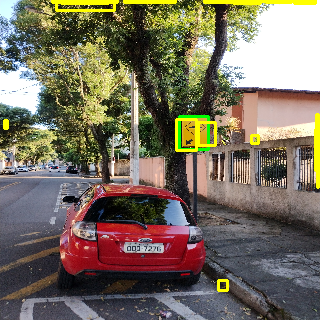

In [84]:
import tensorflow as tf
assert tf.__version__.startswith('2')
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def infer(image_path):
  image = cv2.imread(image_path)
  image_resized = cv2.resize(image, (input_details[0]['shape'][2], input_details[0]['shape'][1]))
  image_blueprinted = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
  image_tensor = tf.convert_to_tensor(image_blueprinted, dtype=tf.uint8)
  image_np = np.expand_dims(image_tensor, axis=0).astype(input_details[0]['dtype'])
  interpreter.set_tensor(input_details[0]['index'], image_np)
  interpreter.invoke()

  output_scores = interpreter.get_tensor(output_details[0]['index'])[0]
  output_boxes = interpreter.get_tensor(output_details[1]['index'])[0]
 
  for i in (range(len(output_boxes))): 
    ymin = output_boxes[i][0]
    xmin = output_boxes[i][1]
    ymax = output_boxes[i][2]
    xmax = output_boxes[i][3]

    xmin = int(xmin * image_resized.shape[1])
    xmax = int(xmax * image_resized.shape[1])
    ymin = int(ymin * image_resized.shape[0])
    ymax = int(ymax * image_resized.shape[0])

    THRESHOLD_VALUE_CONFIDENCE=0.1

    if (output_scores[i]>THRESHOLD_VALUE_CONFIDENCE):
      cv2.rectangle(image_resized, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    else:
      cv2.rectangle(image_resized, (xmin, ymin), (xmax, ymax), (0, 255, 255), 2)
  
  cv2_imshow(image_resized)

# infere("imgs/00172_COCO_train2014_000000496283.jpg")
# infer("example1.jpg")
infer("imgs/IMG_20230318_165604898.jpg")



In [ ]:
# @title dump
  #################################################
  # Pillow -> cv2

  # image = Image.open(image_path)
  # image_resized = image.resize((input_details[0]['shape'][2], input_details[0]['shape'][1]))
  # image_resized = cv2.cvtColor(np.array(image_resized), cv2.COLOR_RGB2BGR)
  #################################################
  # Cropping 

  # height, width, _ = image.shape
  # crop_dim = min(1500,1500)
  # x_start = int((width - crop_dim) / 2)
  # y_start = int((height - crop_dim) / 2)
  # image_cropped = image[y_start:y_start+crop_dim, x_start:x_start+crop_dim]
  # image_resized = cv2.resize(image_cropped, (input_details[0]['shape'][2], input_details[0]['shape'][1]))
  #################################################

In [ ]:
# @title json format tensors
[{
  'name': 'StatefulPartitionedCall:1',
  'index': 600,
  'shape': array([ 1, 25], dtype=int32),
  'shape_signature': array([ 1, 25], dtype=int32),
  'dtype': <class 'numpy.float32'>, 
  'quantization': (0.0, 0),
  'quantization_parameters': {
      'scales': array([], dtype=float32),
      'zero_points': array([], dtype=int32),
      'quantized_dimension': 0},
  'sparsity_parameters': {}
  },
  {
   'name': 'StatefulPartitionedCall:3',
   'index': 598, 
   'shape': array([ 1, 25,  4], dtype=int32),
   'shape_signature': array([ 1, 25,  4], dtype=int32), 
   'dtype': <class 'numpy.float32'>, 
   'quantization': (0.0, 0), 
   'quantization_parameters': {
       'scales': array([], dtype=float32), 
       'zero_points': array([], dtype=int32), 
       'quantized_dimension': 0},
    'sparsity_parameters': {}},
  {
      'name': 'StatefulPartitionedCall:0',
    'index': 601,
    'shape': array([1], dtype=int32), 
   'shape_signature': array([1], dtype=int32),
   'dtype': <class 'numpy.float32'>,
   'quantization': (0.0, 0),
   'quantization_parameters': {
       'scales': array([], dtype=float32),
        'zero_points': array([], dtype=int32), 
        'quantized_dimension': 0}, 
   'sparsity_parameters': {}},
  {
      'name': 'StatefulPartitionedCall:2', 
   'index': 599,
   'shape': array([ 1, 25], dtype=int32), 
   'shape_signature': array([ 1, 25], dtype=int32), 
   'dtype': <class 'numpy.float32'>, 
   'quantization': (0.0, 0), 'quantization_parameters':
   {'scales': array([], dtype=float32), 
    'zero_points': array([], dtype=int32), 
    'quantized_dimension': 0}, 
   'sparsity_parameters': {}
   }]



# Paused/Resumed Training

In [ ]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
from tensorflow import keras
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1CjTZPRJ38fag1k2Fth9RfcsmEyjAJnjd

In [ ]:
!unzip dataset.zip

In [ ]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('speedbumps.csv')

In [ ]:
spec = model_spec.get('efficientdet_lite0')

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/', save_freq='epoch', save_best_only=True)

# Set up the object detector and train the model with the checkpoint callback
detector = object_detector.create(
    train_data,
    model_spec=spec,
    batch_size=32,
    validation_data=validation_data,
    train_whole_model=False,
)

# Train the model on the training data
history = detector.fit(
    train_data,
    epochs=10,
    validation_data=validation_data,
    callbacks=[checkpoint_callback]
)

#AttributeError: 'ObjectDetector' object has no attribute 'fit'

In [ ]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('speedbumps.csv')

# Resume training from a saved checkpoint
detector = object_detector.ObjectDetector.from_saved_model('checkpoints/')
detector.train(
    initial_epoch=10,
    batch_size=8,
    validation_data=validation_data,
    train_whole_model=True,
    callbacks=[checkpoint_callback]
)

In [ ]:
import tensorflow as tf
from tflite_model_maker.models import EfficientDetLite0
from tflite_model_maker.object_detector import DataLoader
from tensorflow.keras.callbacks import ModelCheckpoint
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

# Load data using the DataLoader class
train_data = DataLoader.from_csv('speedbumps.csv')

# Create the EfficientDet model
model = EfficientDetLite0(num_classes=...)
model.build((None, None, None, 3))

# Create an optimizer and compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=model.compute_loss)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model using the fit method and the checkpoint callback
model.fit(train_data, epochs=10, callbacks=[checkpoint_callback])

# Convert the saved Keras model weights to a TFLite model
spec = model_spec.get('efficientdet_lite0')
converter = object_detector.TFLiteConverter.from_keras_model(model.keras_model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Evaluation

In [ ]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

In [ ]:
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
import cv2

interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

In [54]:
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1huDBJdXQca8T_9ekIPCxWa4Zvutj0Utb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From (uriginal): https://drive.google.com/uc?id=1huDBJdXQca8T_9ekIPCxWa4Zvutj0Utb
From (redirected): https://drive.google.com/uc?id=1huDBJdXQca8T_9ekIPCxWa4Zvutj0Utb&confirm=t&uuid=d699c4d3-ee41-42ef-8804-7eba4bc6cea1
To: /content/test_dataset_200_mixed_real.zip
100% 756M/756M [00:18<00:00, 40.7MB/s]


In [ ]:
!unzip dataset.zip

## optimized version (multithreading)

In [ ]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
def parse_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image_resized = tf.image.resize(image, (input_details[0]['shape'][1], input_details[0]['shape'][2]))
  image_blueprinted = tf.image.convert_image_dtype(image_resized, tf.uint8)
  
  return image_blueprinted

def prepare_dataset(image_paths, batch_size=32):
  image_paths_ds = tf.data.Dataset.from_tensor_slices(image_paths)
  images_ds = image_paths_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
  images_ds = images_ds.batch(batch_size)
  return images_ds

def infer(images):
  image_np = np.asarray(images)
  for image in image_np:
    image_tensor = tf.convert_to_tensor(image, dtype=tf.uint8)
    image_np = np.expand_dims(image_tensor, axis=0).astype(input_details[0]['dtype'])
    interpreter.set_tensor(input_details[0]['index'], image_np)
    interpreter.invoke()

    output_classes = interpreter.get_tensor(output_details[0]['index'])
    output_boxes = interpreter.get_tensor(output_details[1]['index'])
    
    bboxes = []
    for i in range(len(output_boxes)):
      ymin = output_boxes[0][i][0]
      xmin = output_boxes[0][i][1]
      ymax = output_boxes[0][i][2]
      xmax = output_boxes[0][i][3]

      xmin = int(xmin * input_details[0]['shape'][2])
      xmax = int(xmax * input_details[0]['shape'][2])
      ymin = int(ymin * input_details[0]['shape'][1])
      ymax = int(ymax * input_details[0]['shape'][1])

      THRESHOLD_VALUE_CONFIDENCE=0.4

      if (output_classes[i]>THRESHOLD_VALUE_CONFIDENCE):
        bboxes.append([xmin, ymin, xmax, ymax, output_classes[i]])

  return bboxes







image_paths = []

with open("speedbumps.csv", 'r') as file:
  csvreader = csv.reader(file)
  for row in tqdm(csvreader):
    if not (row[1] in image_paths):
      image_paths.append(row[1])

batch_size = 32
image_ds = prepare_dataset(image_paths, batch_size=batch_size)

bboxes_all_images = []
for images in image_ds:
  bboxes_single_batch = infer(images)
  bboxes_all_images.extend(bboxes_single_batch)

print(bboxes_all_images)

## normal version

In [91]:
def infer(image_path):
  image = cv2.imread(image_path)
  image_resized = cv2.resize(image, (input_details[0]['shape'][2], input_details[0]['shape'][1]))
  image_blueprinted = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
  image_tensor = tf.convert_to_tensor(image_blueprinted, dtype=tf.uint8)
  image_np = np.expand_dims(image_tensor, axis=0).astype(input_details[0]['dtype'])
  interpreter.set_tensor(input_details[0]['index'], image_np)
  interpreter.invoke()

  output_scores = interpreter.get_tensor(output_details[0]['index'])[0]
  output_boxes = interpreter.get_tensor(output_details[1]['index'])[0]

  bboxes_single_image = []
  for i in (range(len(output_boxes))): 
    ymin = output_boxes[i][0]
    xmin = output_boxes[i][1]
    ymax = output_boxes[i][2]
    xmax = output_boxes[i][3]

    xmin = int(xmin * image_resized.shape[1])
    xmax = int(xmax * image_resized.shape[1])
    ymin = int(ymin * image_resized.shape[0])
    ymax = int(ymax * image_resized.shape[0])

    THRESHOLD_VALUE_CONFIDENCE=0.1

    if (output_scores[i]>THRESHOLD_VALUE_CONFIDENCE):
      bboxes_single_image.append([xmin, ymin, xmax, ymax, output_scores[i]])

  return bboxes_single_image

In [92]:
import csv
from google.colab.patches import cv2_imshow
from tqdm import tqdm

pred_bboxes = []
anno_bboxes = []
images = []

with open("speedbumps.csv", 'r') as file:
  csvreader = csv.reader(file)
  last_sample=""
  gt_single_image=[]
  i=0
  for row in tqdm(csvreader):
    image = cv2.imread(row[1])
    image_resized = cv2.resize(image, (input_details[0]['shape'][2], input_details[0]['shape'][1]))
    # if i==10: break
    
    xmin = int((float)(row[3])*image_resized.shape[1])
    ymin = int((float)(row[4])*image_resized.shape[0])
    xmax = int((float)(row[7])*image_resized.shape[1])
    ymax = int((float)(row[8])*image_resized.shape[0])

    if (last_sample==row[1]):
      gt_single_image.append([xmin, ymin, xmax, ymax])
    else:
      i+=1
      images.append({
          "id":i,
          "file_name":row[1],
          "width":image_resized.shape[1],
          "height":image_resized.shape[0]
        })
      last_sample=row[1]
      if gt_single_image: anno_bboxes.append(gt_single_image)
      pred_bboxes.append(infer(row[1]))
      gt_single_image=[]
      gt_single_image.append([xmin, ymin, xmax, ymax])

  pred_bboxes.pop()
  images.pop()

print()
print(pred_bboxes)
print(anno_bboxes)

259it [12:40,  2.93s/it]


[[[146, 134, 184, 178, 0.99609375]], [[84, 105, 108, 130, 0.984375]], [[223, 69, 246, 91, 0.984375]], [[169, 0, 210, 42, 0.99609375]], [[147, 12, 156, 23, 0.4140625], [247, 151, 255, 160, 0.203125]], [[222, 52, 252, 83, 0.99609375], [159, 165, 186, 197, 0.99609375], [106, 238, 137, 269, 0.99609375]], [[134, 163, 175, 208, 0.99609375], [60, 93, 98, 135, 0.47265625]], [[0, 77, 30, 112, 0.99609375]], [[93, 43, 141, 97, 0.99609375]], [[212, 14, 226, 33, 0.796875], [37, 230, 49, 243, 0.359375]], [[0, 23, 37, 68, 0.99609375], [147, 36, 190, 86, 0.99609375], [101, 27, 147, 80, 0.99609375], [131, 33, 179, 83, 0.26171875]], [[194, 1, 205, 17, 0.5], [86, 201, 95, 215, 0.44140625]], [[114, 10, 136, 34, 0.99609375]], [[64, 69, 91, 95, 0.99609375]], [[262, 210, 275, 223, 0.2421875], [35, 36, 45, 49, 0.16796875]], [[134, 5, 147, 22, 0.69140625]], [[81, 91, 125, 140, 0.99609375]], [[37, 96, 54, 114, 0.81640625]], [[0, 169, 26, 199, 0.99609375]], [[30, 183, 41, 198, 0.5859375]], [[136, 195, 160, 229,

In [93]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from math import floor

def round_special(f: float):
  # print("number: ", f)
  # if f>=0.98: return 1.0
  # elif f>=0.9: return float(str(f)[:4])
  # else: return round(f.astype(float),2)
  return float(str(f)[:4])
  

pred_coco = []
anno_coco = []

imgs_coco = []
annotations = []

for idImg, annotations_on_image in enumerate(anno_bboxes):
  for idAnno, bbox in enumerate(annotations_on_image):
    annotations.append({
        "id":idAnno+idImg+1,
        "image_id":idImg+1,
        "category_id":1,
        "bbox":[bbox[0],bbox[1],bbox[2]-bbox[0],bbox[3]-bbox[1]],
        "area": (bbox[2]-bbox[0])*(bbox[3]-bbox[1]),
        "iscrowd":0
    })
  
  for prediction in pred_bboxes[idImg]:
    
    pred_coco.append({
      "image_id": idImg+1,
      "category_id": 1,
      "bbox": [
          prediction[0],
          prediction[1],
          prediction[2]-prediction[0],
          prediction[3]-prediction[1],
      ], 
      "score":round_special(prediction[4])
    })

    # print(round_special(prediction[4]))

anno_coco = {
    "images":images,
    "annotations": annotations,
    "categories":[
        {"id":1, "name":"speedbumpsign"}
    ]
}

print(pred_coco)

print()

print(anno_coco)

with open('pred_coco.json', 'w') as fp:
    json.dump(pred_coco, fp)

with open('anno_coco.json', 'w') as fp:
    json.dump(anno_coco, fp)


annFile = 'anno_coco.json' 
cocoGt = COCO(annFile)
predFile = 'pred_coco.json'
cocoDt = cocoGt.loadRes(predFile)
cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

[{'image_id': 1, 'category_id': 1, 'bbox': [146, 134, 38, 44], 'score': 0.99}, {'image_id': 2, 'category_id': 1, 'bbox': [84, 105, 24, 25], 'score': 0.98}, {'image_id': 3, 'category_id': 1, 'bbox': [223, 69, 23, 22], 'score': 0.98}, {'image_id': 4, 'category_id': 1, 'bbox': [169, 0, 41, 42], 'score': 0.99}, {'image_id': 5, 'category_id': 1, 'bbox': [147, 12, 9, 11], 'score': 0.41}, {'image_id': 5, 'category_id': 1, 'bbox': [247, 151, 8, 9], 'score': 0.2}, {'image_id': 6, 'category_id': 1, 'bbox': [222, 52, 30, 31], 'score': 0.99}, {'image_id': 6, 'category_id': 1, 'bbox': [159, 165, 27, 32], 'score': 0.99}, {'image_id': 6, 'category_id': 1, 'bbox': [106, 238, 31, 31], 'score': 0.99}, {'image_id': 7, 'category_id': 1, 'bbox': [134, 163, 41, 45], 'score': 0.99}, {'image_id': 7, 'category_id': 1, 'bbox': [60, 93, 38, 42], 'score': 0.47}, {'image_id': 8, 'category_id': 1, 'bbox': [0, 77, 30, 35], 'score': 0.99}, {'image_id': 9, 'category_id': 1, 'bbox': [93, 43, 48, 54], 'score': 0.99}, {'

In [89]:
# algorithm images

# Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
# Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.613
# Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.528
# Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.404
# Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.448
# Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.500
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.566
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.566
# Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.523
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.621
# Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000


# real images

# Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.418
# Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.769
# Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.440
# Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.394
# Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.465
# Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.236
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.475
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.488
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
# Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.456
# Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.539
# Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.233